In [10]:
# Import necessary librariers
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, MeasurementModule
import inspect
import pprint
import pandas as pd
import time as real_time

In [11]:
# Repeatable results
np.random.seed(85)

In [12]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [13]:
# Measurement parameters
pprint.pprint(y['C'])
print(inspect.getsource(y['C']['function']))


{'function': <function generateConfigurations.<locals>.<lambda> at 0x0000022131585940>,
 'noiseVar': 0.01,
 'value': 0}
                'function': lambda x, d: x['C'],



In [14]:
# Measurement module
print(inspect.getsource(MeasurementModule))

def MeasurementModule(y, x, d, f):
    # Add random normal noise to true values for each of the measurements
    for key in y.keys():
        y[key]['value'] = y[key]['function'](x, d) + np.random.normal(0, y[key]['noiseVar'])
        # Check for fault conditions
        if f[key]['state']=="stuck":
            y[key]['value'] = y[key]['value']
        elif f[key]['state']=="bias":
            y[key]['value'] = y[key]['value'] + f[key]['bias']
        elif f[key]['state']=="drift":
            y[key]['value'] = y[key]['value'] + f[key]['drift']
    return y



In [15]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [16]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (days)', 'V', 'xWv', 'L', 'F0', 'FW', 'F', 'C0','C',
                'F0m', 'FWm', 'Fm', 'C0m', 'Cm']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Indicate whether input changes
input_change = False
input_change_time_index = 2000
# Indicate whether fault triggered (drifting sensor)
fault_triggered = True
fault_triggered_time_index = 2000
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']: # necessary while loop, since shuts can skip forward in time
    # Update time (check for jumps from maintenance)
    t['tvector'][t['i']+1] = t['tvector'][t['i']] + t['deltat']
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Current input
    if input_change and [t['i']]>=input_change_time_index:
        u['xWv'] = 0.5
    # Process module
    x = ProcessModule(p, u, d_now, x, f, t)
    # Fault triggered at specific time
    if fault_triggered and t['i']>=fault_triggered_time_index:
        f['C']['state'] = 'drift'
        f['C']['drift'] += f['C']['drift_rate']*p['dt']
    # Measurement module
    y = MeasurementModule(y, x, d_now, f)
    # Update results
    results[t['i'], :] = [t['tvector'][t['i']]/(24*3600), 
                          x['V'], 
                          x['xWv'], 
                          x['L'], 
                          x['F0'], 
                          x['FW'], 
                          x['F'], 
                          d_now['C0'], 
                          x['C'],
                          y['F0']['value'], 
                          y['FW']['value'], 
                          y['F']['value'], 
                          y['C0']['value'], 
                          y['C']['value']]
    # Display progress in percent time
    if t['tvector'][t['i']] % (2*24*3600) == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.14%
14.29%
21.43%
28.57%
35.71%
42.86%
50.00%
57.14%
64.29%
71.43%
78.57%
85.71%
92.86%
Done! Simulation duration: 1.2 seconds.


In [17]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (days)', inplace=True)

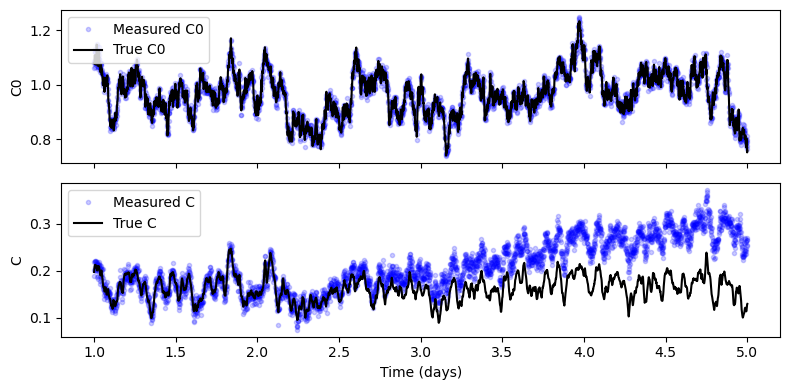

In [18]:
# Plot
state_list = ['C0','C']
measurement_list = [name+'m' for name in state_list]
startInd = 1
endInd = 5
fig, axx = plt.subplots(len(state_list),1,figsize=(8,4),sharex=True)
for ind, state in enumerate(state_list):
    df.loc[startInd:endInd,measurement_list[ind]].plot(label='Measured '+state, color='blue',marker='.',alpha=0.2,linestyle='none',ax=axx[ind])
    df.loc[startInd:endInd,state].plot(color='black',label='True '+state,ax=axx[ind])
    axx[ind].set_ylabel(state)
    axx[ind].legend()
plt.tight_layout()
